# 朴素贝叶斯分类器
----
数据集来自UCI spambase 垃圾邮件数据集。通过处理将远数据集按照3：7的比例分为了训练集和测试集。
http://archive.ics.uci.edu/ml/datasets/spambase

In [2]:
import os
with open("./train.data","r") as file_spambase:
   spambasedata=file_spambase.readlines()

训练用数据集的大小为 3224

In [3]:
len(spambasedata)

3224

每行数据共58行，分别是：

|     |单词出现频率|字符出现频率|平均词长|最长词长|总词长|分类|
|----|----|----|----|----|----|----|
|个数| 48 |  6 |  1 |  1 |  1 |  1 |
|类型|实数|实数|实数|整数|整数|布尔|

In [4]:
spambasedata[0]

'0,0.64,0.64,0,0.32,0,0,0,0,0,0,0.64,0,0,0,0.32,0,1.29,1.93,0,0.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.778,0,0,3.756,61,278,1\n'

In [5]:
spambase_list=[]
for sample in spambasedata:
    sample=sample[:-1]
    sample=sample.split(",")
    if len(sample)==58:
        sample=[float(feature) for feature in sample]
        sample[-3]=int(sample[-3]/10)
        sample[-2]=int(sample[-2]/100)
        spambase_list.append(sample)

### 首先求样本中正例和负例的频率（该频率表示为先验概率）

In [6]:
positive_frequency=0.0 #为“1”的概率
negetive_frequency=0.0 #为“0”的概率
#把为“1”的和为“0”的分类
positive_samples=[] 
negetive_samples=[]
for sample in spambase_list:
    if sample[-1]==1:
        positive_samples.append(sample)
    else:
        negetive_samples.append(sample)
#计算频率值
positive_frequency=len(positive_samples)/len(spambase_list)
negetive_frequency=len(negetive_samples)/len(spambase_list)

In [7]:
print(positive_frequency)
print(negetive_frequency)
print(int(positive_samples[0][-2]))
print(len(positive_samples))
print(len(negetive_samples))

0.3939205955334988
0.6060794044665012
2
1270
1954


### 第二步，为每个属性估计条件概率P(Xi | c)

基于贝叶斯分类器来计算P(c|x)需先做属性条件独立性假设。对于离散属性只需用频率表示其条件概率，对于连续属性，假设其服从正态分布，然后考虑其概率密度函数。
离散属性有最长词长，总词长。为修正未出现过的数据，进行平滑处理

In [8]:
import numpy as np
# np.ones() 创建指定形状的数组，数组元素以 1 来填充
length_longest_positive=np.ones(100)
length_longest_negetive=np.ones(100)
length_total_positive=np.ones(500)
length_total_negetive=np.ones(500)
# 统计相同最长词长的个数
for sample in positive_samples:
    if sample[-3]<100:
        length_longest_positive[int(sample[-3])]+=1
    if sample[-2]<500:
        length_total_positive[int(sample[-2])]+=1
for sample in negetive_samples:
    if sample[-3]<100:
        length_longest_negetive[int(sample[-3])]+=1
    if sample[-2]<500:
        length_total_negetive[int(sample[-2])]+=1
#计算最长词长的频率（每个位置的数除以总数）
length_longest_positive/=length_longest_positive.sum()
length_longest_negetive/=length_longest_negetive.sum()
length_total_positive/=length_total_positive.sum()
length_total_negetive/=length_total_negetive.sum()

假设连续属性服从正态分布，求其概率密度时只需求分布函数的均值和方差即可

In [9]:
# np.zeros() 创建指定大小的数组，数组元素以 0 来填充：
words_average_positive=np.zeros(56)
words_average_negetive=np.zeros(56)
words_variance_positive=np.zeros(56)
words_variance_negetive=np.zeros(56)
for i in range(56):
    feature_list=[feature[i] for feature in positive_samples]
    #numpy.mean() 函数返回数组中元素的算术平均值。 如果提供了轴，则沿其计算。
    words_average_positive[i]=np.array(feature_list,dtype='float').mean()
    #numpy.var() 函数返回数组中元素的方差
    words_variance_positive[i]=np.array(feature_list,dtype='float').var()
for i in range(56):
    feature_list=[feature[i] for feature in negetive_samples]
    words_average_negetive[i]=np.array(feature_list,dtype='float').mean()
    words_variance_negetive[i]=np.array(feature_list,dtype='float').var()

到这里就进行完了所有的训练过程，下面在训练集上先测试一下正确率

In [10]:
guess_right=0
guess_error=0
for sample in spambase_list:
    try:
        p_positive=1
        p_negetive=1
        guess_class=0
        #算出对应的 P(c | X) (连续变量，假定正态分布)
        for i in range(56):
            p_negetive*=np.exp(-pow(sample[i]-words_average_negetive[i],2)/(2*words_variance_negetive[i]))/np.sqrt(2*np.pi*words_variance_negetive[i])
        #p_negetive*=length_longest_negetive[int(sample[55])]
        #p_negetive*=length_total_negetive[int(sample[56])]
        for i in range(56):
            p_positive*=np.exp(-pow(sample[i]-words_average_positive[i],2)/(2*words_variance_positive[i]))/np.sqrt(2*np.pi*words_variance_positive[i])
        #p_positive*=length_longest_positive[int(sample[55])]
        #p_positive*=length_total_positive[int(sample[56])]

        #如果为“1”概率大于为"0"概率，判别为1
        if p_positive>p_negetive:
            guess_class=1
        #统计正确和错误的个数
        if guess_class==sample[-1]:
            guess_right+=1 
        else:
            guess_error+=1
    except:
        print(sample)
print(guess_right)
print(guess_error)

2625
599


In [11]:
guess_right/(guess_right+guess_error)

0.8142059553349876

采取这种分类措施在训练集上的分类识别率达到0.81.下面使用测试集检验结果。

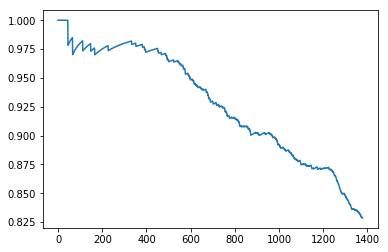

1141
236


In [20]:
import matplotlib.pyplot as plt
with open("./test.data","r") as file_spambase:
   spambasedata_test=file_spambase.readlines()
spambase_test_list=[]
for sample in spambasedata_test:
    sample=sample[:-1]
    sample=sample.split(",")
    if len(sample)==58:
        sample=[float(feature) for feature in sample]
        sample[-3]=int(sample[-3]/10)
        sample[-2]=int(sample[-2]/100)
        spambase_test_list.append(sample)
guess_right=0
guess_error=0
guess_f = []
for sample in spambase_test_list:
    try:
        p_positive=1
        p_negetive=1
        for i in range(56):
            p_negetive*=np.exp(-pow(sample[i]-words_average_negetive[i],2)/(2*words_variance_negetive[i]))/np.sqrt(2*np.pi*words_variance_negetive[i])
        #p_negetive*=length_longest_negetive[int(sample[55])]
        #p_negetive*=length_total_negetive[int(sample[56])]
        for i in range(56):
            p_positive*=np.exp(-pow(sample[i]-words_average_positive[i],2)/(2*words_variance_positive[i]))/np.sqrt(2*np.pi*words_variance_positive[i])
        #p_positive*=length_longest_positive[int(sample[55])]
        #p_positive*=length_total_positive[int(sample[56])]
        guess_class=0
        if p_positive>p_negetive:
            guess_class=1
        if guess_class==sample[-1]:
            guess_right+=1
        else:
            guess_error+=1
        guess_f.append(guess_right/(guess_right+guess_error))
    except:
        print(sample)
x = np.linspace(0, len(guess_f),len(guess_f))
y = guess_f
plt.plot(x, y)
plt.show()
print(guess_right)
print(guess_error)

In [44]:
with open("./get_the_flag.data","r") as file_spambase:
   spambasedata_flag=file_spambase.readlines()
spambase_flag_list=[]
for sample in spambasedata_flag :
    sample=sample.split(",")
    if len(sample)==57:
        sample=[float(feature) for feature in sample]
        sample[-3]=int(sample[-3]/10)
        sample[-2]=int(sample[-2]/100)
        spambase_flag_list.append(sample)
guess_flag_right=0
guess_flag_error=0
flag = []
for sample in spambase_flag_list:
    p_positive=1
    p_negetive=1
    for i in range(56):
        p_negetive*=np.exp(-pow(sample[i]-words_average_negetive[i],2)/(2*words_variance_negetive[i]))/np.sqrt(2*np.pi*words_variance_negetive[i])
        #p_negetive*=length_longest_negetive[int(sample[55])]
        #p_negetive*=length_total_negetive[int(sample[56])]
    for i in range(56):
        p_positive*=np.exp(-pow(sample[i]-words_average_positive[i],2)/(2*words_variance_positive[i]))/np.sqrt(2*np.pi*words_variance_positive[i])
        #p_positive*=length_longest_positive[int(sample[55])]
        #p_positive*=length_total_positive[int(sample[56])]
    guess_flag_class=0
    if p_positive>p_negetive:
        flag.append(1)
    else:
        flag.append(0)
print(len(spambase_flag_list))

560


In [45]:
forcase_end = []
i = 0
t = 0
while i < 560:
    if flag[i] == 1 :
        t = t + 1
    if i % 10 == 0 :
        if t > 5 :
            forcase_end.append(1)
        else :
            forcase_end.append(0)
        t = 0
    i = i + 1 
print(forcase_end[1:])

[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
